In [32]:
import numpy as np
import pandas as pd
import math
from scipy import stats
from itertools import combinations
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt


housing_data = pd.read_csv('boston.csv').drop('B', axis = 1)  #Import data
housing_data.dropna()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,6.48,22.0


In [2]:
def train_test_split(data, train_ratio):
  #Note that data shuffling occurs in the fit functions of the model classes
  data = data.sample(frac=1).reset_index(drop = True)
  num_train = int(train_ratio * len(data))
  train = data.iloc[:num_train][:]
  test = data.iloc[num_train:][:]
  return [train, test]

test_train = train_test_split(housing_data, 0.8)
train, test = test_train[0], test_train[1]

x_train, y_train = train.iloc[:,:-1], train.iloc[:,-1]
x_test, y_test = test.iloc[:,:-1], test.iloc[:,-1]

In [3]:
def get_coefficients(x, y):
    b = np.linalg.inv(x.T @ x) @ x.T @ y
    return b

In [4]:
def predict(x, b):
    return x @ b

In [5]:
def kfold_cross_validation(data, k, add_bias = False, verbose = True):
    metrics_test = {'mse': [], 'r2': []}
    data = data.sample(frac=1).reset_index(drop=True)  # Shuffle data
    fold_size = len(data) // k

    for i in range(k):
        test = data.iloc[i*fold_size:(i+1)*fold_size]
        train = pd.concat([data.iloc[:i*fold_size], data.iloc[(i+1)*fold_size:]], axis=0)

        x_train, y_train = train.iloc[:,:-1].values, train.iloc[:,-1].values
        x_test, y_test = test.iloc[:,:-1].values, test.iloc[:,-1].values

        # Add bias
        if add_bias:
            x_train = np.column_stack([x_train,np.ones(x_train.shape[0])])
            x_test = np.column_stack([x_test,np.ones(x_test.shape[0])])

        b = get_coefficients(x_train, y_train)
        test_predictions = predict(x_test, b)

        # Calculate metrics
        mse = mean_squared_error(y_test, test_predictions)
        r2 = r2_score(y_test, test_predictions)

        # Append metrics
        metrics_test['mse'].append(mse)
        metrics_test['r2'].append(r2)

    # Calculate average metrics
    avg_metrics = {metric: np.mean(values) for metric, values in metrics_test.items()}

    if verbose:
        print(f'Average test MSE: {avg_metrics["mse"]}\n')
        print(f'Average test R^2: {avg_metrics["r2"]}\n')

    return avg_metrics["mse"]


In [6]:
kfold_cross_validation(housing_data, 5, add_bias = True)

Average test MSE: 25.06976219752395

Average test R^2: 0.695904121044473



25.06976219752395

# Interactions

In [7]:
## Return data set with interaction features

def get_significant_interactions(data):

    x, y = data.iloc[:,:-1], data.iloc[:,-1]
    poly = PolynomialFeatures(interaction_only=True)
    x_interactions = poly.fit_transform(x)

    coefs = get_coefficients(x_interactions, y)
    predictions = predict(x_interactions, coefs)
    residuals = y.values - predictions

    n = x_interactions.shape[0]
    p = x_interactions.shape[1]
    dof = n - p - 1

    # Mean Squared Error of residuals
    mse = (residuals ** 2).sum() / dof

    # Variance-Covariance Matrix
    cov_matrix = mse * np.linalg.inv(x_interactions.T @ x_interactions)

    # Standard errors
    se = np.sqrt(np.diag(cov_matrix))

    # t-statistics
    t_stats = coefs / se

    p_values = [2 * (1 - stats.t.cdf(np.abs(t), df=dof)) for t in t_stats]

    temp = ([1]*13 + [x < 0.05 for x in p_values][13:])*coefs
    significant_mask = temp != 0

    return significant_mask

In [8]:
def include_interactions(data, mask):
    x = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    poly = PolynomialFeatures(interaction_only=True)
    new_x = poly.fit_transform(x)
    new_x = new_x[:, mask]
    new_data = pd.DataFrame(new_x, columns=np.array(poly.get_feature_names_out(x.columns))[mask])
    new_data['target'] = y.values
    return new_data

In [9]:
mask = get_significant_interactions(housing_data)
data = include_interactions(housing_data, mask)

kfold_cross_validation(data, 5)

Average test MSE: 14.65946389269418

Average test R^2: 0.8241183549171295



14.65946389269418

# Gaussian Features

In [10]:
def gaussian(x, mean, var):
  return np.exp(-((x - mean) ** 2) / (2 * var))

def add_gaussians(data, exclude_features):
    target = data.iloc[:, -1]
    features = data.iloc[:, :-1]
    new_data = features.copy()

    for column in features:
      if all(name not in column for name in exclude_features) and ' ' not in column:
            mean = np.mean(features[column])
            gaussian_column = features[column].apply(gaussian, args=(mean, 1))
            if (gaussian_column != 0).any():  # Exclude Gaussian-transformed features that are all zeros
                new_data[f'{column} (gaussian)'] = gaussian_column

    new_data[target.name] = target  # Ensure the target variable remains as the last column
    return new_data

In [11]:
def get_significant_gaussians(data, exclude):

    y = data.iloc[:, -1]
    x_gaussians = add_gaussians(data, exclude).iloc[:,:-1]

    coefs = get_coefficients(x_gaussians, y)
    predictions = predict(x_gaussians.values, coefs.values)
    residuals = y.values - predictions

    n = x_gaussians.shape[0]
    p = x_gaussians.shape[1]
    dof = n - p - 1

    # Mean Squared Error of residuals
    mse = (residuals ** 2).sum() / dof

    # Variance-Covariance Matrix
    cov_matrix = mse * np.linalg.inv(x_gaussians.T @ x_gaussians)

    # Standard errors
    se = np.sqrt(np.diag(cov_matrix))

    # t-statistics
    t_stats = coefs / se

    p_values = [2 * (1 - stats.t.cdf(np.abs(t), df=dof)) for t in t_stats]

    temp = ([1]*33 + [x < 0.05 for x in p_values][33:])*coefs
    significant_mask = temp != 0

    x_gaussians = x_gaussians.loc[:, x_gaussians.columns[significant_mask]]
    x_gaussians['target'] = y
    return x_gaussians

In [12]:
enriched_data = add_gaussians(data, ['1', 'MEDV', 'CHAS', 'RAD', 'TAX'])

In [13]:
enriched_data = get_significant_gaussians(data, ['1', 'MEDV', 'CHAS', 'RAD', 'TAX', 'target'])

In [14]:
kfold_cross_validation(enriched_data, 5)

Average test MSE: 14.880112488081569

Average test R^2: 0.8226056659488666



14.880112488081569

# Feature Selection

In [15]:
enriched_data

,1,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,...,RM LSTAT,AGE RAD,AGE LSTAT,DIS LSTAT,TAX PTRATIO,CRIM (gaussian),INDUS (gaussian),RM (gaussian),DIS (gaussian),target
0,1.0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,...,32.74350,65.2,324.696,20.368200,4528.8,0.001495,1.206756e-17,0.958720,0.957433,24.0
1,1.0,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,...,58.68794,157.8,721.146,45.399294,4307.6,0.001612,2.562533e-04,0.990745,0.503154,21.6
2,1.0,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,...,28.95555,122.2,246.233,20.017413,4307.6,0.001612,2.562533e-04,0.666757,0.503154,34.7
3,1.0,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,...,20.57412,137.4,134.652,17.822868,4151.4,0.001641,3.798437e-18,0.775347,0.076535,33.4
4,1.0,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,...,38.09351,162.6,288.886,32.311526,4151.4,0.001870,3.798437e-18,0.689466,0.076535,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,1.0,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,...,63.75431,69.1,668.197,23.968062,5733.0,0.001828,7.300808e-01,0.953568,0.420416,22.4
502,1.0,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,...,55.56960,76.7,696.436,20.770500,5733.0,0.001719,7.300808e-01,0.986539,0.320991,20.6
503,1.0,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,...,39.34464,91.0,513.240,12.224700,5733.0,0.001816,7.300808e-01,0.787420,0.265950,23.9
504,1.0,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,...,44.02512,89.3,578.664,15.480072,5733.0,0.002158,7.300808e-01,0.878335,0.372090,22.0


In [16]:
def greedy_feature_selection(data):

    table = {}

    while True:
        current_features = data.iloc[:, :-1]
        performance_improved = False
        performances = []
        for i in range(5):
            performances.append(kfold_cross_validation(data, 5, verbose=False))
        mean_performance = np.mean(performances)

        for feature in current_features:
            data_copy = data.copy()
            data_copy.pop(feature)
            new_performances = []
            for i in range(5):
                new_performances.append(kfold_cross_validation(data_copy, 5, verbose=False))
            mean_new_performance = np.mean(new_performances)
            table[feature] = mean_new_performance

        if min(table.values()) < mean_performance:
            new_data = data.copy()
            new_data.pop(min(table, key=table.get))
            data = new_data
            del table[min(table, key=table.get)]
            performance_improved = True

        if not performance_improved:
            break

    return data, mean_performance

In [17]:
selected_data = greedy_feature_selection(enriched_data)[0]
kfold_cross_validation(selected_data, 5)

Average test MSE: 14.785406984048228

Average test R^2: 0.8272321134994799



14.785406984048228

In [18]:
selected_data.shape

(506, 29)

# Regularization

In [19]:

def get_coefficients(x, y, reg = None, lambdaa = 0):

    if reg == 'L2':
        b = np.linalg.inv(x.T @ x + lambdaa * np.identity(x.shape[1])) @ x.T @ y
        return b
    else:
        b = np.linalg.inv(x.T @ x) @ x.T @ y
        return b

In [20]:
def kfold_cross_validation(data, k, reg = None, lambdaa = 0, add_bias = False, verbose = True):
    metrics_test = {'mse': [], 'r2': []}
    data = data.sample(frac=1).reset_index(drop=True)  # Shuffle data
    fold_size = len(data) // k

    for i in range(k):
        test = data.iloc[i*fold_size:(i+1)*fold_size]
        train = pd.concat([data.iloc[:i*fold_size], data.iloc[(i+1)*fold_size:]], axis=0)

        x_train, y_train = train.iloc[:,:-1].values, train.iloc[:,-1].values
        x_test, y_test = test.iloc[:,:-1].values, test.iloc[:,-1].values

        # Add bias
        if add_bias:
            x_train = np.column_stack([x_train,np.ones(x_train.shape[0])])
            x_test = np.column_stack([x_test,np.ones(x_test.shape[0])])

        b = get_coefficients(x_train, y_train, reg, lambdaa)
        test_predictions = predict(x_test, b)

        # Calculate metrics
        mse = mean_squared_error(y_test, test_predictions)
        r2 = r2_score(y_test, test_predictions)

        # Append metrics
        metrics_test['mse'].append(mse)
        metrics_test['r2'].append(r2)

    # Calculate average metrics
    avg_metrics = {metric: np.mean(values) for metric, values in metrics_test.items()}

    if verbose:
        print(f'Average test MSE: {avg_metrics["mse"]}\n')
        print(f'Average test R^2: {avg_metrics["r2"]}\n')

    return avg_metrics["mse"]

In [21]:
for lambdaa in [0, 0.001, 0.01, 0.1, 0.5]:
    mse = kfold_cross_validation(selected_data, 5, 'L2', 0.1, verbose = False)
    print(f'Regularization strength: {lambdaa},    Test MSE: {mse}')

Regularization strength: 0,    Test MSE: 15.163871092292982
Regularization strength: 0.001,    Test MSE: 15.441662268561515
Regularization strength: 0.01,    Test MSE: 13.435158552884719
Regularization strength: 0.1,    Test MSE: 14.769880067830533
Regularization strength: 0.5,    Test MSE: 13.998110621526985


## Diagnostics

In [229]:
def plot_residuals_vs_fitted(data):

    x = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    coef = get_coefficients(x, y)
    y_pred = predict(x, np.array(coef))

    residuals = y - y_pred
    std_residuals = (residuals - np.mean(residuals))/np.std(residuals)
    sqrt_standardized_residuals = np.sqrt(np.abs(std_residuals))

    # Calculate leverage values (hat matrix diagonal)
    x = np.array(x)
    hat_matrix = x @ np.linalg.inv(x.T @ x) @ x.T
    leverage = np.diag(hat_matrix)

    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Residuals vs. Fitted Values
    axs[0, 0].scatter(y_pred, residuals, alpha=0.5, color='cadetblue')
    axs[0, 0].axhline(y=0, color='b', linestyle='--', linewidth=1)
    axs[0, 0].set_xlabel('Fitted Values')
    axs[0, 0].set_ylabel('Residuals')
    axs[0, 0].set_title('Residuals vs. Fitted Values')
    axs[0, 0].spines[['right', 'top']].set_visible(False)
  
    # Scale-Location Plot
    axs[0, 1].scatter(y_pred, sqrt_standardized_residuals, alpha=0.5, color='cadetblue')
    axs[0, 1].axhline(y=np.mean(sqrt_standardized_residuals), color='blue', linestyle='--', linewidth=1)
    axs[0, 1].set_xlabel('Fitted Values')
    axs[0, 1].set_ylabel('Sqrt(Standardized Residuals)')
    axs[0, 1].set_title('Scale-Location Plot')
    axs[0, 1].spines[['right', 'top']].set_visible(False)

    # Manually position the centered plot to match the size of the other subplots
    ax = axs[1, 0]
    stats.probplot(residuals, dist="norm", plot=ax)
    ax.set_title('QQ Plot of Residuals')
    ax.spines[['right', 'top']].set_visible(False)

    # Customize the QQ plot line
    qqline = ax.get_lines()[1]
    qqline.set_color('blue')
    qqline.set_linestyle('--')
    qqline.set_linewidth(1)

    qqmarkers = ax.get_lines()[0]
    qqmarkers.set_markerfacecolor('cadetblue')
    qqmarkers.set_markeredgecolor('cadetblue')
    qqmarkers.set_alpha(0.5)


    # Residuals vs. Leverage with Cook's distance
    scatter = axs[1, 1].scatter(leverage, std_residuals, alpha=0.5, color='cadetblue')
    axs[1, 1].set_xlabel('Leverage')
    axs[1, 1].set_ylabel('Standerdized Residuals')
    axs[1, 1].set_title('Residuals vs. Leverage')
    axs[1, 1].spines[['right', 'top']].set_visible(False)
    
    # Add Cook's distance contours
    leverage_space = np.linspace(0.01, max(leverage), 100)
    cooks_critical = np.sqrt((1 * len(coef) * (1 - leverage_space)) / leverage_space)
    axs[1, 1].plot(leverage_space, cooks_critical, color='b', linestyle='--', label="Cook's distance (D = 1)", linewidth = 1)
    axs[1, 1].plot(leverage_space, -cooks_critical, color='b', linestyle='--', linewidth = 1)
    axs[1, 1].legend(frameon = False)

    plt.tight_layout()
    plt.show()


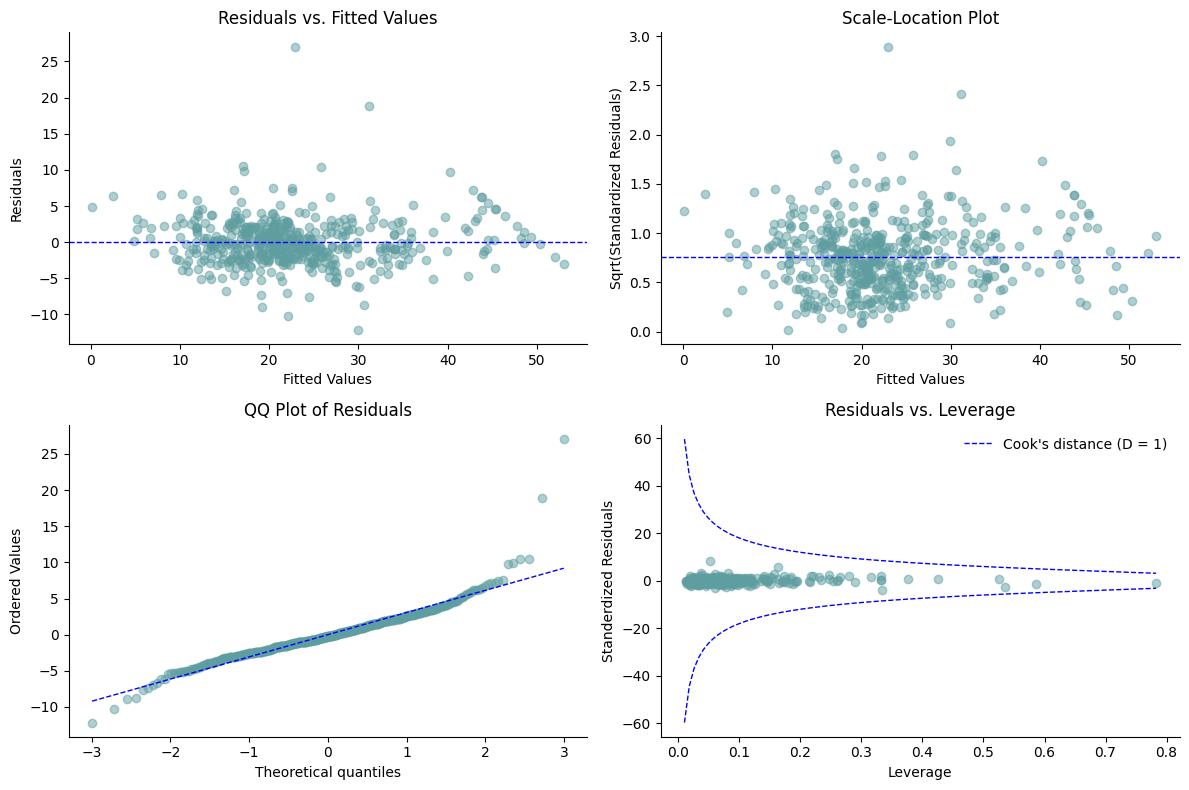

In [230]:
plot_residuals_vs_fitted(enriched_data)